<a href="https://colab.research.google.com/github/asthaasati/Model-Evaluation-and-Hyperparameter-Tuning/blob/main/Model_Evaluation_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [13]:
df = pd.read_csv('/content/Walmart_sales_analysis.csv')

In [14]:
df.sample()

,Store_Number,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3200,23,2/18/2011,"1,369,972",0,26.6,3.263,133,5.114


In [16]:
df.shape

(6435, 8)

In [18]:
df.isnull().sum()

,0
Store_Number,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [19]:
df['Weekly_Sales'] = df['Weekly_Sales'].str.replace(',', '').astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
median_sales = df['Weekly_Sales'].median()
df['High_Sales'] = (df['Weekly_Sales'] > median_sales).astype(int)

In [22]:
df_model = df.drop(columns=['Date', 'Weekly_Sales'])

In [23]:
df.head()

,Store_Number,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,High_Sales
0,1,2010-02-05,1643691.0,0,42.31,2.572,211,8.106,2010,2,5,1
1,1,2010-02-12,1641957.0,1,38.51,2.548,211,8.106,2010,2,6,1
2,1,2010-02-19,1611968.0,0,39.93,2.514,211,8.106,2010,2,7,1
3,1,2010-02-26,1409728.0,0,46.63,2.561,211,8.106,2010,2,8,1
4,1,2010-03-05,1554807.0,0,46.50,2.625,211,8.106,2010,3,9,1


In [24]:
df.shape

(6435, 12)

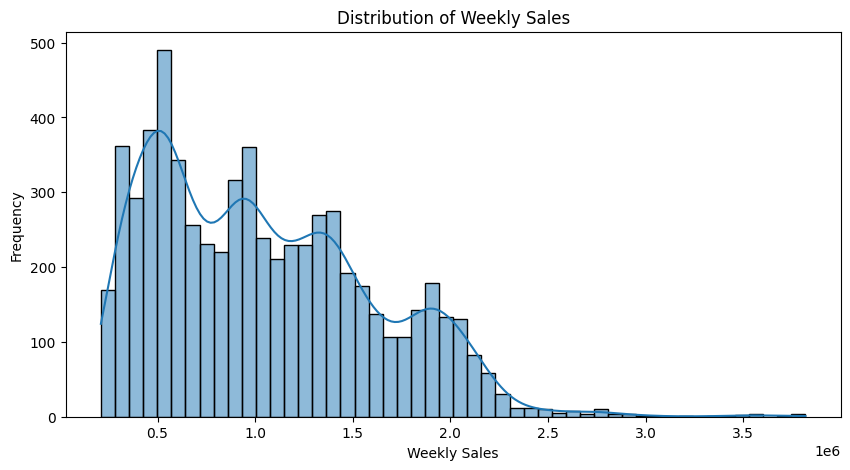

In [39]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

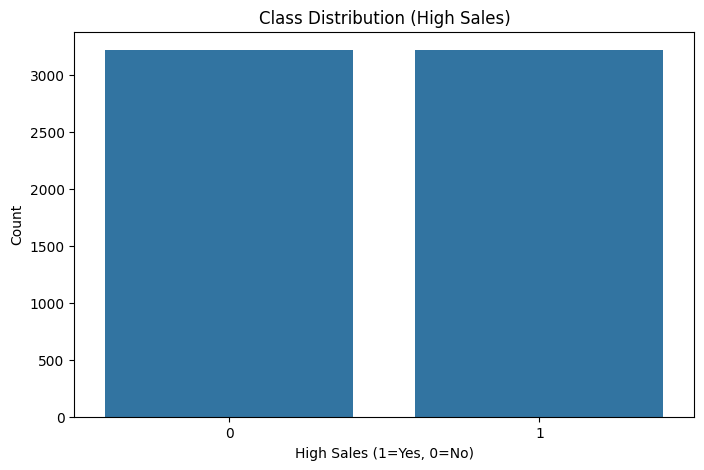

In [40]:
plt.figure(figsize=(8, 5))
sns.countplot(x='High_Sales', data=df)
plt.title('Class Distribution (High Sales)')
plt.xlabel('High Sales (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

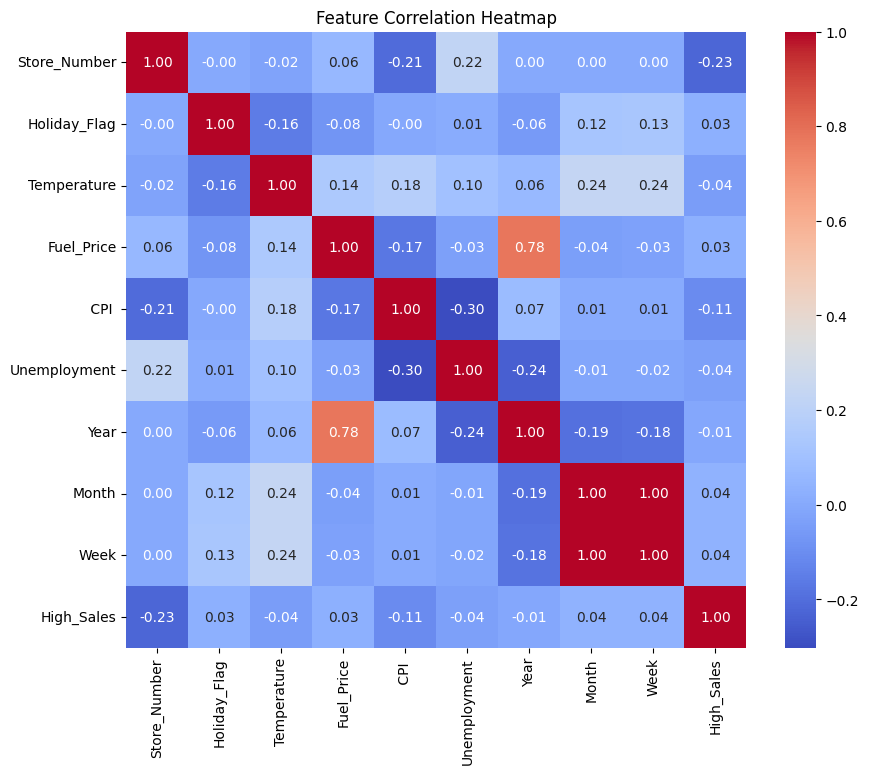

In [41]:
corr = df_model.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [25]:
X = df_model.drop(columns=['High_Sales'])
y = df_model['High_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [28]:
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print("Initial Model Results:\n", results_df.sort_values(by='F1-Score', ascending=False))

Initial Model Results:
                  Model  Accuracy  Precision    Recall  F1-Score
1        Random Forest  0.952603   0.945372  0.961420  0.953328
3                  KNN  0.806527   0.815166  0.796296  0.805621
2                  SVM  0.745921   0.743551  0.756173  0.749809
0  Logistic Regression  0.634033   0.622746  0.692901  0.655953


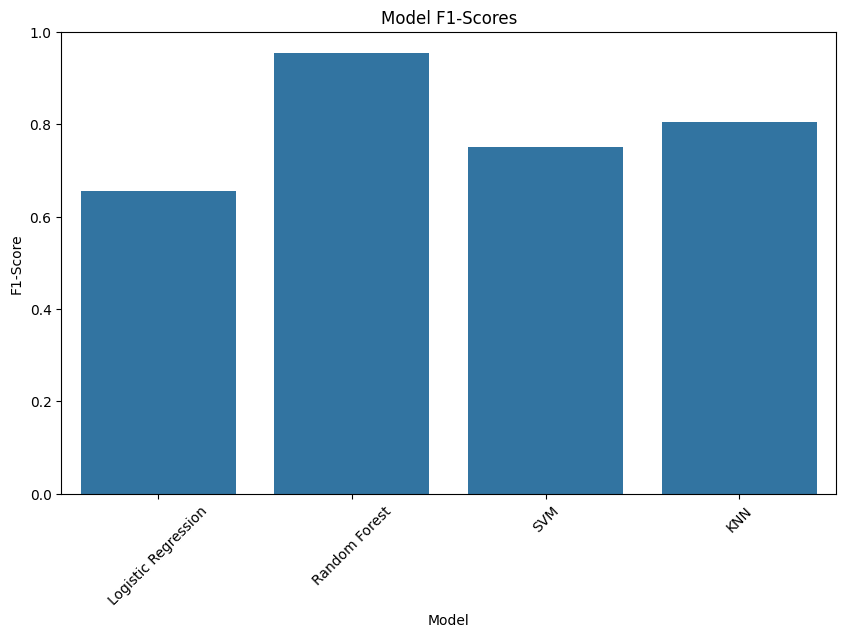

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=results_df)
plt.title('Model F1-Scores')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [29]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

In [31]:
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=rf_param_grid,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)
rf_random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='f1')

In [32]:
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
rf_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [33]:
best_models = {
    'RandomizedSearchCV': rf_random_search.best_estimator_,
    'GridSearchCV': rf_grid_search.best_estimator_
}


In [34]:
tuning_results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    tuning_results.append({
        'Tuning Method': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

In [35]:
tuning_df = pd.DataFrame(tuning_results)
print("Tuned Model Results:\n", tuning_df.sort_values(by='F1-Score', ascending=False))

Tuned Model Results:
         Tuning Method  Accuracy  Precision    Recall  F1-Score
1        GridSearchCV  0.953380   0.946809  0.961420  0.954058
0  RandomizedSearchCV  0.951826   0.946646  0.958333  0.952454


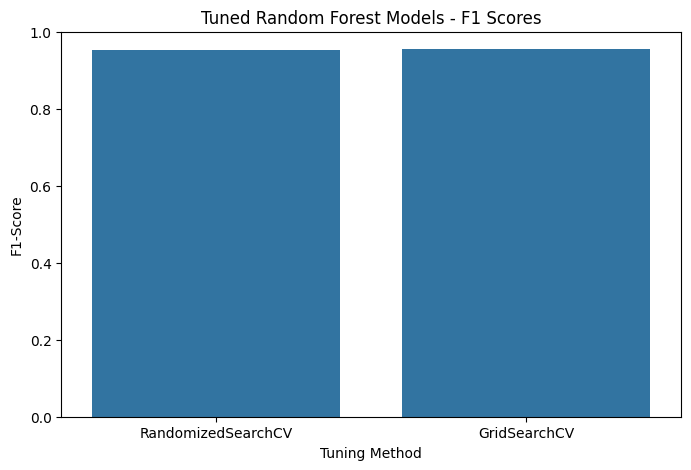

In [38]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Tuning Method', y='F1-Score', data=tuning_df)
plt.title('Tuned Random Forest Models - F1 Scores')
plt.ylim(0, 1)
plt.show()